Device utilisé : cuda
✅ Poids chargés avec succès.

📂 Classe : 049_Cnidaria
🖼️ Image : 55.jpg
🎭 Masque : Non trouvé ❌


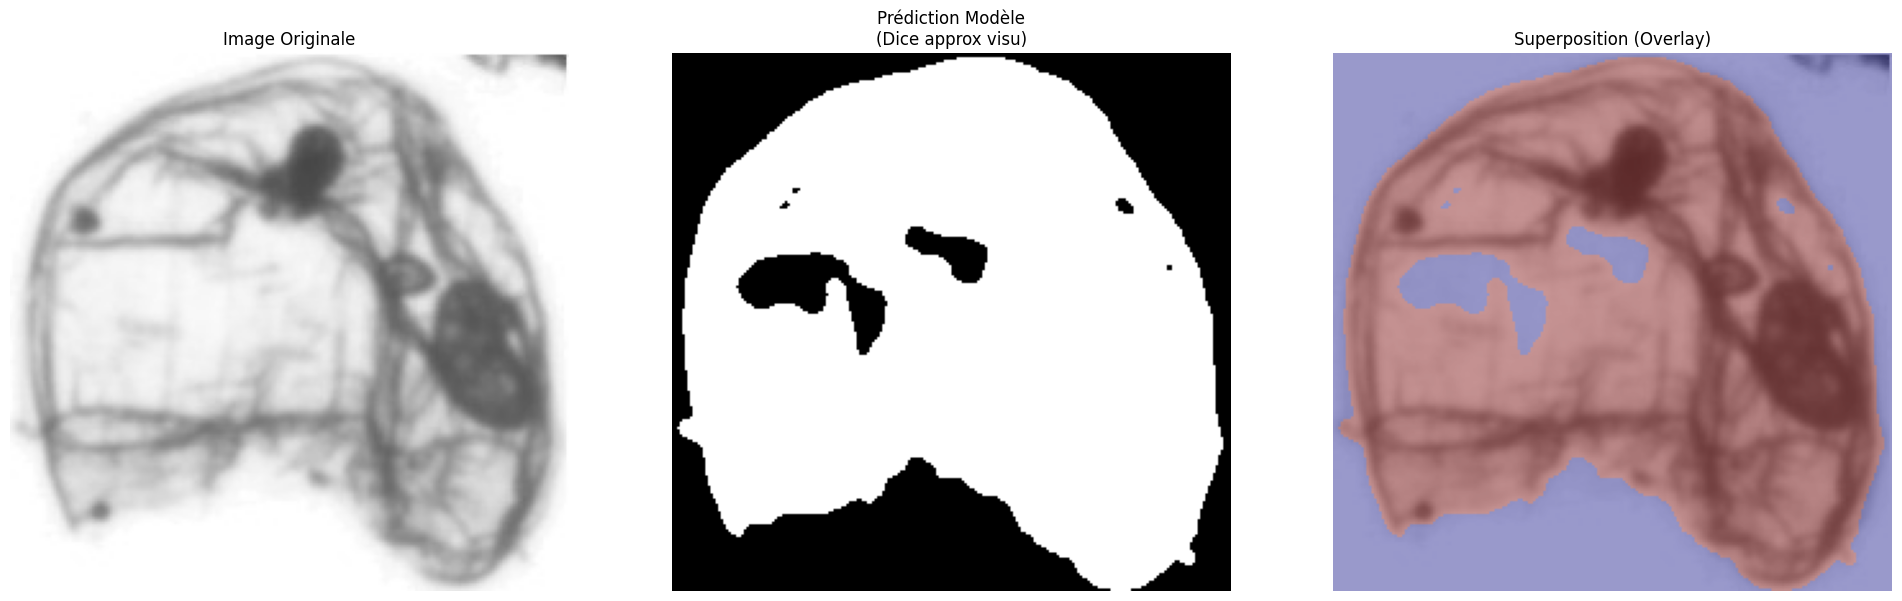

In [19]:
# --- CELLULE 1 : IMPORTS & CONFIGURATION ---
import os
import random
import glob
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# ---------------- CONFIGURATION À ADAPTER ----------------
# Chemin vers tes données d'entraînement
DATASET_ROOT = r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\data\original_dataset\train" 

# Chemin vers ton modèle entraîné (.pt)
MODEL_PATH = r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\logs\Unet_20\best_model.pt" # <--- Vérifie ce chemin

# Paramètres du modèle (DOIVENT ÊTRE IDENTIQUES À L'ENTRAÎNEMENT)
MODEL_ARCH = "Unet"
BACKBONE = "resnet34"
IMG_SIZE = 448
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Import de tes modèles (Assure-toi que torchtmpl est accessible)
try:
    from torchtmpl.models.seg_models import DeepLabV3Plus, Unet, DeepLabV3, UnetPlusPlus
except ImportError:
    print("⚠️ ERREUR : Impossible d'importer 'torchtmpl'. Vérifie que tu es dans le bon dossier ou que le package est installé.")

# Mapping des architectures
MODEL_MAP = {
    "Unet": Unet,
    "DeepLabV3": DeepLabV3,
    "DeepLabV3Plus": DeepLabV3Plus,
    "UnetPlusPlus": UnetPlusPlus
}

print(f"Device utilisé : {DEVICE}")


# --- CELLULE 2 : FONCTIONS DE CHARGEMENT ---

def load_inference_model(path, arch, backbone, device):
    """Charge le modèle en mode évaluation."""
    if arch not in MODEL_MAP:
        raise ValueError(f"Architecture {arch} inconnue.")
    
    # Init architecture
    cfg = {"backbone": backbone, "pretrained": False}
    model = MODEL_MAP[arch](cfg, (3, IMG_SIZE, IMG_SIZE), 1) # 1 classe
    
    # Load weights
    if not os.path.exists(path):
        raise FileNotFoundError(f"Modèle introuvable ici : {path}")
        
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint
    
    try:
        model.load_state_dict(state_dict)
        print("✅ Poids chargés avec succès.")
    except Exception as e:
        print(f"⚠️ Erreur chargement strict, tentative en loose mode... {e}")
        model.load_state_dict(state_dict, strict=False)
        
    model.to(device)
    model.eval()
    return model

def get_random_sample(root_dir):
    """
    Parcourt les sous-dossiers (classes) et tire une image au hasard.
    Tente de deviner le chemin du masque.
    """
    # Liste toutes les classes (sous-dossiers)
    classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    if not classes:
        # Cas où les images sont directement dans root_dir
        print("Pas de sous-dossiers 'classes' trouvés, recherche directe...")
        image_list = glob.glob(os.path.join(root_dir, "*.jpg")) + glob.glob(os.path.join(root_dir, "*.png"))
        class_name = "Racine"
    else:
        # Choix d'une classe au hasard
        class_name = random.choice(classes)
        class_path = os.path.join(root_dir, class_name)
        image_list = glob.glob(os.path.join(class_path, "*.jpg")) + glob.glob(os.path.join(class_path, "*.png"))
    
    if not image_list:
        raise FileNotFoundError(f"Aucune image trouvée dans {class_name}")

    img_path = random.choice(image_list)
    
    # --- TENTATIVE DE TROUVER LE MASQUE (À ADAPTER SELON TA STRUCTURE) ---
    # Hypothèse courante : dossier parallèle 'masks' ou suffixe '_mask'
    # Ici, j'assume une structure simple, sinon on renvoie None
    mask_path = None
    
    # Exemple 1 : data/train/images/img.jpg -> data/train/masks/img.png
    potential_mask = img_path.replace("images", "masks").replace(".jpg", ".png")
    if os.path.exists(potential_mask):
        mask_path = potential_mask
    
    # Exemple 2 : Si tes masques sont dans le même dossier
    potential_mask_2 = os.path.splitext(img_path)[0] + "_mask.png"
    if os.path.exists(potential_mask_2):
        mask_path = potential_mask_2

    return img_path, mask_path, class_name


# --- CELLULE 3 : PRÉDICTION ET VISUALISATION ---

def predict_and_show():
    # 1. Charger le modèle (une seule fois si possible, mais ici on le fait pour l'exemple)
    model = load_inference_model(MODEL_PATH, MODEL_ARCH, BACKBONE, DEVICE)
    
    # 2. Récupérer une image
    img_path, mask_path, class_name = get_random_sample(DATASET_ROOT)
    print(f"\n📂 Classe : {class_name}")
    print(f"🖼️ Image : {os.path.basename(img_path)}")
    print(f"🎭 Masque : {'Trouvé ✅' if mask_path else 'Non trouvé ❌'}")

    # 3. Prétraitement
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    h_orig, w_orig = original_img.shape[:2]

    # Pipeline identique à l'entraînement
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Resize pour le modèle
    img_resized = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)

    # 4. Inférence
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits)
        # Threshold 0.5
        pred_mask_small = (probs > 0.5).squeeze().cpu().numpy().astype(np.uint8)

    # 5. Redimensionner le masque prédit à la taille originale
    pred_mask = cv2.resize(pred_mask_small, (w_orig, h_orig), interpolation=cv2.INTER_NEAREST)

    # 6. Chargement Masque Vérité Terrain (si dispo)
    gt_mask = None
    if mask_path:
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Binarisation de sécurité
        if gt_mask is not None:
            _, gt_mask = cv2.threshold(gt_mask, 127, 1, cv2.THRESH_BINARY)

    # 7. AFFICHAGE
    fig, axs = plt.subplots(1, 4 if gt_mask is not None else 3, figsize=(20, 6))

    # Image Originale
    axs[0].imshow(original_img)
    axs[0].set_title("Image Originale")
    axs[0].axis("off")

    # Vérité Terrain
    idx = 1
    if gt_mask is not None:
        axs[idx].imshow(gt_mask, cmap='gray')
        axs[idx].set_title("Vérité Terrain (Ground Truth)")
        axs[idx].axis("off")
        idx += 1

    # Prédiction
    axs[idx].imshow(pred_mask, cmap='gray')
    axs[idx].set_title(f"Prédiction Modèle\n(Dice approx visu)")
    axs[idx].axis("off")
    idx += 1

    # Overlay (Superposition)
    axs[idx].imshow(original_img)
    axs[idx].imshow(pred_mask, alpha=0.4, cmap='jet') # Le masque en transparence
    axs[idx].set_title("Superposition (Overlay)")
    axs[idx].axis("off")

    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
predict_and_show()


🔄 Chargement du modèle Unet sur cuda...
✅ Modèle prêt.

📂 Classe : 081_Isias
🖼️ Fichier : 28.jpg
🎭 GT Masque : ❌ Non trouvé


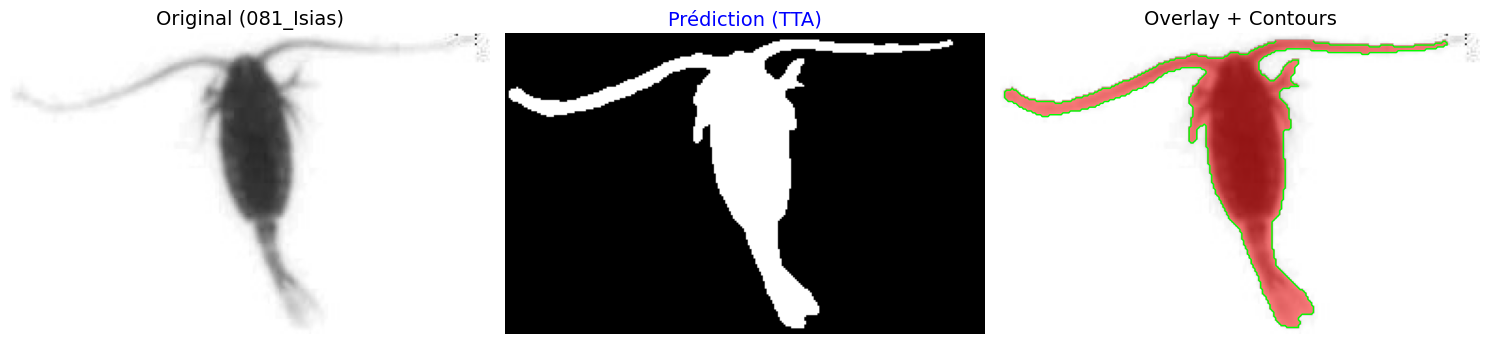

In [ ]:
# --- CELLULE 1 : IMPORTS & CONFIGURATION ---
import os
import random
import glob
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, List, Tuple, Union
from torchvision import transforms

# --- CONFIGURATION ---
@dataclass
class Config:
    # Chemins
    DATASET_ROOT: Path = Path(r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\data\original_dataset\train")
    # MODEL_PATH: Path = Path(r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\logs\Unet_11\best_model.pt")
    MODEL_PATH: Path = Path(r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\logs\Unet_21\best_model.pt")
    
    # Paramètres Modèle
    ARCH: str = "Unet"          # Architecture
    BACKBONE: str = "resnet34"  # Encoder
    IMG_SIZE: int = 448         # Taille d'entrée (doit être divisible par 32)
    NUM_CLASSES: int = 1        # Segmentation binaire
    
    # Inférence
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
    USE_TTA: bool = True        # Activer Test Time Augmentation

    # Normalisation (ImageNet defaults)
    MEAN: Tuple[float, ...] = (0.485, 0.456, 0.406)
    STD: Tuple[float, ...] = (0.229, 0.224, 0.225)

config = Config()

# --- IMPORT DYNAMIQUE DES MODÈLES ---
try:
    from torchtmpl.models.seg_models import DeepLabV3Plus, Unet, DeepLabV3, UnetPlusPlus
    MODEL_MAP = {
        "Unet": Unet,
        "DeepLabV3": DeepLabV3,
        "DeepLabV3Plus": DeepLabV3Plus,
        "UnetPlusPlus": UnetPlusPlus
    }
except ImportError:
    raise ImportError("⚠️ Le package 'torchtmpl' est introuvable. Vérifiez votre PYTHONPATH.")


# --- CELLULE 2 : MOTEUR D'INFÉRENCE & TTA ---

class PlanktonInferencer:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.model = self._load_model()
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=cfg.MEAN, std=cfg.STD)
        ])

    def _load_model(self):
        """Charge le modèle et les poids en mode strict ou loose."""
        print(f"🔄 Chargement du modèle {self.cfg.ARCH} sur {self.cfg.DEVICE}...")
        
        if self.cfg.ARCH not in MODEL_MAP:
            raise ValueError(f"Architecture inconnue: {self.cfg.ARCH}")
            
        model_cls = MODEL_MAP[self.cfg.ARCH]
        # Configuration spécifique à torchtmpl
        model_cfg = {"backbone": self.cfg.BACKBONE, "pretrained": False}
        model = model_cls(model_cfg, (3, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE), self.cfg.NUM_CLASSES)
        
        if not self.cfg.MODEL_PATH.exists():
            raise FileNotFoundError(f"❌ Poids non trouvés: {self.cfg.MODEL_PATH}")

        checkpoint = torch.load(self.cfg.MODEL_PATH, map_location=self.cfg.DEVICE)
        state_dict = checkpoint.get("model_state_dict", checkpoint)
        
        try:
            model.load_state_dict(state_dict)
        except RuntimeError as e:
            print(f"⚠️ Chargement strict échoué, tentative en 'strict=False'. Erreur: {e}")
            model.load_state_dict(state_dict, strict=False)
            
        model.to(self.cfg.DEVICE)
        model.eval()
        print("✅ Modèle prêt.")
        return model

    def predict(self, img_rgb: np.ndarray) -> np.ndarray:
        """
        Exécute la prédiction. Si TTA est activé, utilise Flip H/V et Rotations.
        """
        # Preprocessing
        img_resized = cv2.resize(img_rgb, (self.cfg.IMG_SIZE, self.cfg.IMG_SIZE))
        tensor = self.transform(img_resized).to(self.cfg.DEVICE)
        
        if not self.cfg.USE_TTA:
            # Mode simple (Batch size = 1)
            with torch.no_grad():
                logits = self.model(tensor.unsqueeze(0))
                probs = torch.sigmoid(logits)
        else:
            # Mode TTA (Test Time Augmentation)
            # On construit un batch avec l'image et ses variations géométriques
            # Cela gère parfaitement les planctons non centrés ou orientés bizarrement.
            probs = self._predict_tta_batch(tensor)

        # Redimensionnement vers la taille d'origine
        mask_pred = F.interpolate(
            probs, 
            size=(img_rgb.shape[0], img_rgb.shape[1]), 
            mode='bilinear', 
            align_corners=False
        )
        
        # Binarisation (CPU numpy)
        return (mask_pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    def _predict_tta_batch(self, tensor: torch.Tensor, mode: str = "vote") -> torch.Tensor:
        """
        TTA avec stratégies d'agrégation avancées (CORRIGÉ).
        Correction : L'ordre des transformations inverses pour les cas combinés (5, 6, 7)
        a été inversé pour correspondre mathématiquement à l'aller.
        """
        dims = [1, 2] # [H, W] pour les dimensions spatiales

        # --- 1. GÉNÉRATION DES 8 VUES (FORWARD) ---
        # Ordre appliqué : Rotation d'abord, Flip ensuite (pour les cas combinés)
        imgs = [
            tensor,                                                      # 0. Original
            torch.rot90(tensor, k=1, dims=dims),                         # 1. Rot 90
            torch.rot90(tensor, k=2, dims=dims),                         # 2. Rot 180
            torch.rot90(tensor, k=3, dims=dims),                         # 3. Rot 270
            torch.flip(tensor, dims=[2]),                                # 4. Flip H
            torch.flip(torch.rot90(tensor, k=1, dims=dims), dims=[2]),   # 5. Transpose (Rot90 + FlipH)
            torch.flip(torch.rot90(tensor, k=2, dims=dims), dims=[2]),   # 6. Flip V    (Rot180 + FlipH)
            torch.flip(torch.rot90(tensor, k=3, dims=dims), dims=[2]),   # 7. Anti-Trans(Rot270 + FlipH)
        ]

        batch = torch.stack(imgs)

        # --- 2. INFÉRENCE BATCH ---
        with torch.no_grad():
            logits = self.model(batch.to(self.cfg.DEVICE))
            probs = torch.sigmoid(logits)  # [8, 1, H, W]

        # --- 3. REMISE À L'ENDROIT (INVERSE TRANSFORMATIONS) ---
        # Règle : Si Forward = Flip(Rot(x)), alors Inverse = Rot_inv(Flip(y))
        # Il faut donc appliquer le Flip d'abord, PUIS la rotation inverse.
        
        # Cas Simples
        p_orig   = probs[0]
        p_rot90  = torch.rot90(probs[1], k=-1, dims=dims)
        p_rot180 = torch.rot90(probs[2], k=-2, dims=dims)
        p_rot270 = torch.rot90(probs[3], k=-3, dims=dims)
        p_fliph  = torch.flip(probs[4], dims=[2])
        
        # Cas Combinés (C'est ici que c'était faux)
        # On "défait" le Flip d'abord (car c'était la dernière opération à l'aller)
        # Puis on "défait" la rotation
        
        # 5. Transpose : On flip, PUIS on tourne de -90
        p_trans = torch.rot90(torch.flip(probs[5], dims=[2]), k=-1, dims=dims)
        
        # 6. Flip V : On flip, PUIS on tourne de -180
        p_flipv = torch.rot90(torch.flip(probs[6], dims=[2]), k=-2, dims=dims)
        
        # 7. Anti-Transpose : On flip, PUIS on tourne de -270
        p_antitrans = torch.rot90(torch.flip(probs[7], dims=[2]), k=-3, dims=dims)

        # Empilement
        stack_probs = torch.stack([
            p_orig, p_rot90, p_rot180, p_rot270, 
            p_fliph, p_flipv, p_trans, p_antitrans
        ])

        # --- 4. STRATÉGIES D'AGRÉGATION ---
        if mode == "mean":
            final_prob = torch.mean(stack_probs, dim=0)

        elif mode == "max":
            # Le max devrait maintenant être parfaitement aligné
            final_prob, _ = torch.max(stack_probs, dim=0)

        elif mode == "vote":
            votes = (stack_probs > 0.5).float()
            vote_sum = torch.sum(votes, dim=0)
            final_prob = (vote_sum >= 5).float() # Majorité absolue (5/8)

        else:
            raise ValueError(f"Mode TTA inconnu: {mode}")

        return final_prob.unsqueeze(0)



# --- CELLULE 3 : GESTION DES DONNÉES ---

class DataManager:
    @staticmethod
    def get_random_sample(root_dir: Path) -> Tuple[Path, Optional[Path], str]:
        """Récupère une image et son masque potentiel."""
        if not root_dir.exists():
            raise FileNotFoundError(f"Dossier introuvable: {root_dir}")

        # Recherche récursive des sous-dossiers
        subdirs = [d for d in root_dir.iterdir() if d.is_dir()]
        
        if not subdirs:
            # Pas de structure de classe, on cherche direct
            images = list(root_dir.glob("*.jpg")) + list(root_dir.glob("*.png"))
            class_name = root_dir.name
        else:
            # Choix aléatoire d'une classe
            selected_dir = random.choice(subdirs)
            images = list(selected_dir.glob("*.jpg")) + list(selected_dir.glob("*.png"))
            class_name = selected_dir.name
            
        if not images:
            raise FileNotFoundError(f"Aucune image dans {class_name}")
            
        img_path = random.choice(images)
        
        # --- LOGIQUE DE RECHERCHE DE MASQUE ---
        # 1. Cherche dans un dossier parallèle "masks"
        # data/train/CLASS/img.jpg -> data/masks/CLASS/img.png
        mask_candidate_1 = str(img_path).replace("original_dataset", "masks_dataset").replace(".jpg", ".png")
        # Adapte selon ta structure exacte :
        mask_candidate_2 = img_path.parent / "masks" / (img_path.stem + ".png")
        
        mask_path = None
        if os.path.exists(mask_candidate_1):
            mask_path = Path(mask_candidate_1)
        elif mask_candidate_2.exists():
            mask_path = mask_candidate_2

        return img_path, mask_path, class_name


# --- CELLULE 4 : VISUALISATION ---

def visualize_results(img_orig: np.ndarray, mask_pred: np.ndarray, mask_gt: Optional[np.ndarray], class_name: str):
    """Affiche les résultats proprement."""
    
    num_plots = 4 if mask_gt is not None else 3
    fig, axs = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6))
    
    # 1. Image Originale
    axs[0].imshow(img_orig)
    axs[0].set_title(f"Original ({class_name})", fontsize=14)
    axs[0].axis("off")
    
    current_idx = 1
    
    # 2. Vérité Terrain (si dispo)
    if mask_gt is not None:
        axs[current_idx].imshow(mask_gt, cmap='gray')
        axs[current_idx].set_title("Ground Truth", fontsize=14, color='green')
        axs[current_idx].axis("off")
        current_idx += 1
        
    # 3. Prédiction
    axs[current_idx].imshow(mask_pred, cmap='gray')
    axs[current_idx].set_title("Prédiction (TTA)", fontsize=14, color='blue')
    axs[current_idx].axis("off")
    current_idx += 1
    
    # 4. Superposition
    axs[current_idx].imshow(img_orig)
    # Création d'un masque overlay coloré (jaune/transparent)
    masked_overlay = np.ma.masked_where(mask_pred == 0, mask_pred)
    axs[current_idx].imshow(masked_overlay, cmap='autumn', alpha=0.5) 
    
    # Contour pour netteté
    contours, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Astuce matplotlib pour dessiner des contours vectoriels par dessus
        for contour in contours:
            axs[current_idx].plot(contour[:, 0, 0], contour[:, 0, 1], color='lime', linewidth=1)

    axs[current_idx].set_title("Overlay + Contours", fontsize=14)
    axs[current_idx].axis("off")
    
    plt.tight_layout()
    plt.show()

# --- EXECUTION PRINCIPALE ---

def main():
    # 1. Init
    inferencer = PlanktonInferencer(config)
    
    # 2. Data
    try:
        img_path, mask_path, class_name = DataManager.get_random_sample(config.DATASET_ROOT)
        print(f"\n📂 Classe : {class_name}")
        print(f"🖼️ Fichier : {img_path.name}")
        print(f"🎭 GT Masque : {'✅ Trouvé' if mask_path else '❌ Non trouvé'}")
    except Exception as e:
        print(f"Erreur data : {e}")
        return

    # 3. Chargement Image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    gt_mask = None
    if mask_path:
        gt = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        # Resize GT si nécessaire pour l'affichage uniquement, mais idéalement on garde la taille originale
        # Ici on binarise
        _, gt_mask = cv2.threshold(gt, 127, 1, cv2.THRESH_BINARY)

    # 4. Inférence
    pred_mask = inferencer.predict(img)

    # 5. Visu
    visualize_results(img, pred_mask, gt_mask, class_name)

if __name__ == "__main__":
    main()


🔄 Chargement Unet...
Traite : 20461.jpg (Format 448x448)


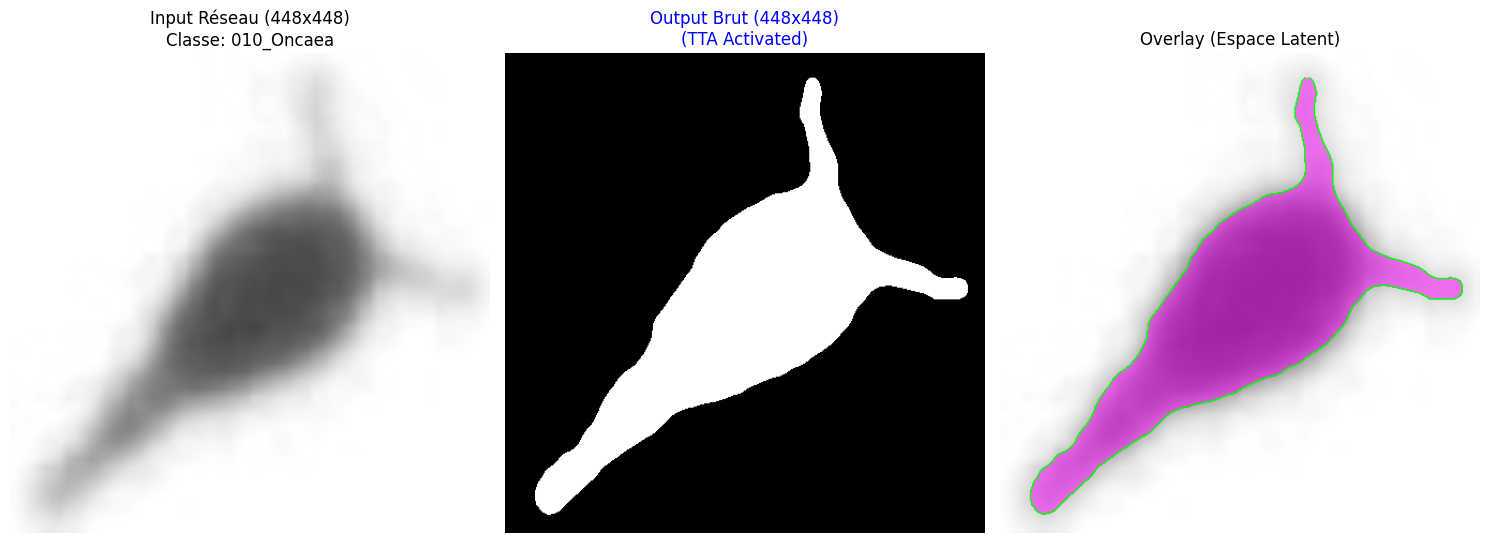

In [ ]:
# --- CELLULE 1 : IMPORTS & CONFIGURATION (VERSION RESIZED) ---
import os
import random
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, List, Tuple
from torchvision import transforms

# --- CONFIGURATION ---
@dataclass
class Config:
    # Chemins
    DATASET_ROOT: Path = Path(r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\data\original_dataset\train")
    MODEL_PATH: Path = Path(r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\logs\Unet_20\best_model.pt")
    # MODEL_PATH: Path = Path(r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\logs\DeepLabV3Plus_2\best_model.pt")
    
    # Paramètres Modèle
    ARCH: str = "Unet"
    BACKBONE: str = "resnet34"
    IMG_SIZE: int = 448         # Taille EXACTE utilisée par le réseau
    NUM_CLASSES: int = 1
    
    # Inférence
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
    USE_TTA: bool = True        # Test Time Augmentation

    # Normalisation
    MEAN: Tuple[float, ...] = (0.485, 0.456, 0.406)
    STD: Tuple[float, ...] = (0.229, 0.224, 0.225)

config = Config()

# --- IMPORT DYNAMIQUE ---
try:
    from torchtmpl.models.seg_models import DeepLabV3Plus, Unet, DeepLabV3, UnetPlusPlus
    MODEL_MAP = {"Unet": Unet, "DeepLabV3": DeepLabV3, "DeepLabV3Plus": DeepLabV3Plus, "UnetPlusPlus": UnetPlusPlus}
except ImportError:
    raise ImportError("⚠️ Le package 'torchtmpl' est introuvable.")


# --- CELLULE 2 : MOTEUR D'INFÉRENCE (OUTPUT RESIZED) ---

class PlanktonInferencerResized:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.model = self._load_model()
        # Transformation sans resize (car on va le faire manuellement avant pour récupérer l'image)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=cfg.MEAN, std=cfg.STD)
        ])

    def _load_model(self):
        print(f"🔄 Chargement {self.cfg.ARCH}...")
        model_cls = MODEL_MAP[self.cfg.ARCH]
        model = model_cls({"backbone": self.cfg.BACKBONE, "pretrained": False}, 
                          (3, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE), self.cfg.NUM_CLASSES)
        
        checkpoint = torch.load(self.cfg.MODEL_PATH, map_location=self.cfg.DEVICE)
        state_dict = checkpoint.get("model_state_dict", checkpoint)
        
        try:
            model.load_state_dict(state_dict)
        except:
            model.load_state_dict(state_dict, strict=False)
            
        model.to(self.cfg.DEVICE)
        model.eval()
        return model

    def predict_resized(self, img_resized_rgb: np.ndarray, mode="vote") -> np.ndarray:
        """
        Prend une image DÉJÀ redimensionnée en (IMG_SIZE, IMG_SIZE).
        Retourne le masque en (IMG_SIZE, IMG_SIZE).
        """
        tensor = self.transform(img_resized_rgb).to(self.cfg.DEVICE)
        
        if self.cfg.USE_TTA:
            probs = self._predict_tta_batch(tensor, mode=mode)
        else:
            with torch.no_grad():
                logits = self.model(tensor.unsqueeze(0))
                probs = torch.sigmoid(logits)

        # PAS d'interpolation vers la taille d'origine ici !
        # On reste dans l'espace tensoriel du réseau
        mask_pred = probs.squeeze().cpu().numpy()
        return (mask_pred > 0.5).astype(np.uint8)

    def _predict_tta_batch(self, tensor: torch.Tensor, mode: str = "vote") -> torch.Tensor:
        """
        TTA avec stratégies d'agrégation avancées (CORRIGÉ).
        Correction : L'ordre des transformations inverses pour les cas combinés (5, 6, 7)
        a été inversé pour correspondre mathématiquement à l'aller.
        """
        dims = [1, 2] # [H, W] pour les dimensions spatiales

        # --- 1. GÉNÉRATION DES 8 VUES (FORWARD) ---
        # Ordre appliqué : Rotation d'abord, Flip ensuite (pour les cas combinés)
        imgs = [
            tensor,                                                      # 0. Original
            torch.rot90(tensor, k=1, dims=dims),                         # 1. Rot 90
            torch.rot90(tensor, k=2, dims=dims),                         # 2. Rot 180
            torch.rot90(tensor, k=3, dims=dims),                         # 3. Rot 270
            torch.flip(tensor, dims=[2]),                                # 4. Flip H
            torch.flip(torch.rot90(tensor, k=1, dims=dims), dims=[2]),   # 5. Transpose (Rot90 + FlipH)
            torch.flip(torch.rot90(tensor, k=2, dims=dims), dims=[2]),   # 6. Flip V    (Rot180 + FlipH)
            torch.flip(torch.rot90(tensor, k=3, dims=dims), dims=[2]),   # 7. Anti-Trans(Rot270 + FlipH)
        ]

        batch = torch.stack(imgs)

        # --- 2. INFÉRENCE BATCH ---
        with torch.no_grad():
            logits = self.model(batch.to(self.cfg.DEVICE))
            probs = torch.sigmoid(logits)  # [8, 1, H, W]

        # --- 3. REMISE À L'ENDROIT (INVERSE TRANSFORMATIONS) ---
        # Règle : Si Forward = Flip(Rot(x)), alors Inverse = Rot_inv(Flip(y))
        # Il faut donc appliquer le Flip d'abord, PUIS la rotation inverse.
        
        # Cas Simples
        p_orig   = probs[0]
        p_rot90  = torch.rot90(probs[1], k=-1, dims=dims)
        p_rot180 = torch.rot90(probs[2], k=-2, dims=dims)
        p_rot270 = torch.rot90(probs[3], k=-3, dims=dims)
        p_fliph  = torch.flip(probs[4], dims=[2])
        
        # Cas Combinés (C'est ici que c'était faux)
        # On "défait" le Flip d'abord (car c'était la dernière opération à l'aller)
        # Puis on "défait" la rotation
        
        # 5. Transpose : On flip, PUIS on tourne de -90
        p_trans = torch.rot90(torch.flip(probs[5], dims=[2]), k=-1, dims=dims)
        
        # 6. Flip V : On flip, PUIS on tourne de -180
        p_flipv = torch.rot90(torch.flip(probs[6], dims=[2]), k=-2, dims=dims)
        
        # 7. Anti-Transpose : On flip, PUIS on tourne de -270
        p_antitrans = torch.rot90(torch.flip(probs[7], dims=[2]), k=-3, dims=dims)

        # Empilement
        stack_probs = torch.stack([
            p_orig, p_rot90, p_rot180, p_rot270, 
            p_fliph, p_flipv, p_trans, p_antitrans
        ])

        # --- 4. STRATÉGIES D'AGRÉGATION ---
        if mode == "mean":
            final_prob = torch.mean(stack_probs, dim=0)

        elif mode == "max":
            # Le max devrait maintenant être parfaitement aligné
            final_prob, _ = torch.max(stack_probs, dim=0)

        elif mode == "vote":
            votes = (stack_probs > 0.5).float()
            vote_sum = torch.sum(votes, dim=0)
            final_prob = (vote_sum >= 5).float() # Majorité absolue (5/8)

        else:
            raise ValueError(f"Mode TTA inconnu: {mode}")

        return final_prob.unsqueeze(0)


# --- CELLULE 3 : DATA & VISU (MODE INSPECTION) ---

def get_random_sample(root_dir: Path):
    """Même logique de chargement"""
    subdirs = [d for d in root_dir.iterdir() if d.is_dir()]
    if not subdirs: return None, None, "Unknown" # Simplifié pour l'exemple
    
    selected_dir = random.choice(subdirs)
    images = list(selected_dir.glob("*.jpg")) + list(selected_dir.glob("*.png"))
    if not images: raise FileNotFoundError("Empty class")
    
    img_path = random.choice(images)
    
    # Recherche masque (adapter selon structure)
    mask_candidate = str(img_path).replace("original_dataset", "masks_dataset").replace(".jpg", ".png")
    mask_path = Path(mask_candidate) if os.path.exists(mask_candidate) else None
    
    return img_path, mask_path, selected_dir.name

def visualize_resized(img_res, mask_pred, mask_gt_res, class_name, img_size):
    num_plots = 4 if mask_gt_res is not None else 3
    fig, axs = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6))
    
    # 1. Input du réseau
    axs[0].imshow(img_res)
    axs[0].set_title(f"Input Réseau ({img_size}x{img_size})\nClasse: {class_name}", fontsize=12)
    axs[0].axis("off")
    
    idx = 1
    # 2. GT Redimensionnée
    if mask_gt_res is not None:
        axs[idx].imshow(mask_gt_res, cmap='gray')
        axs[idx].set_title(f"Ground Truth (Resized)\nPerte de détails possible", fontsize=12, color='green')
        axs[idx].axis("off")
        idx += 1
        
    # 3. Output Réseau
    axs[idx].imshow(mask_pred, cmap='gray')
    axs[idx].set_title(f"Output Brut ({img_size}x{img_size})\n(TTA Activated)", fontsize=12, color='blue')
    axs[idx].axis("off")
    idx += 1
    
    # 4. Overlay Pixel-Perfect
    axs[idx].imshow(img_res)
    masked_overlay = np.ma.masked_where(mask_pred == 0, mask_pred)
    axs[idx].imshow(masked_overlay, cmap='spring', alpha=0.5)
    
    # Contours bruts
    contours, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        axs[idx].plot(c[:, 0, 0], c[:, 0, 1], color='lime', linewidth=1)
        
    axs[idx].set_title("Overlay (Espace Latent)", fontsize=12)
    axs[idx].axis("off")
    
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---

def main_resized():
    inferencer = PlanktonInferencerResized(config)
    
    img_path, mask_path, class_name = get_random_sample(config.DATASET_ROOT)
    print(f"Traite : {img_path.name} (Format {config.IMG_SIZE}x{config.IMG_SIZE})")

    # 1. Charger Originaux
    img_orig = cv2.imread(str(img_path))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    # 2. RESIZE MANUEL (Pour simuler l'entrée exacte du réseau)
    img_resized = cv2.resize(img_orig, (config.IMG_SIZE, config.IMG_SIZE))
    
    mask_gt_resized = None
    if mask_path:
        mask_orig = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        # IMPORTANT: Resize masque en Nearest Neighbor pour garder 0 et 1 (pas de gris)
        mask_gt_resized = cv2.resize(mask_orig, (config.IMG_SIZE, config.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        _, mask_gt_resized = cv2.threshold(mask_gt_resized, 127, 1, cv2.THRESH_BINARY)

    # 3. Inférence sur l'image resized
    pred_mask = inferencer.predict_resized(img_resized)

    # 4. Visu
    visualize_resized(img_resized, pred_mask, mask_gt_resized, class_name, config.IMG_SIZE)

if __name__ == "__main__":
    main_resized()


In [ ]:
# --- CELLULE 4 : GÉNÉRATION DU GIF POUR LE README ---
import imageio.v2 as imageio  # Si pas installé : pip install imageio
# Si imageio pose problème, on peut le faire avec PIL uniquement, dis-le moi.
from PIL import Image as PILImage
import time

def create_gif_frame(img_rgb, mask_pred, img_size):
    """
    Crée une image composite (3 panneaux) pour une frame du GIF.
    Layout : [ORIGINAL] | [MASQUE BINAIRE] | [OVERLAY + CONTOURS]
    """
    # 1. Panneau Original
    panel_1 = img_rgb.copy()
    
    # 2. Panneau Masque (Convertir 0/1 -> 0/255 RGB)
    panel_2 = np.stack([mask_pred*255]*3, axis=-1).astype(np.uint8)
    
    # 3. Panneau Overlay
    # Fond
    panel_3 = img_rgb.copy()
    
    # Masque rouge semi-transparent
    overlay = np.zeros_like(panel_3)
    overlay[:, :, 0] = 255 # Rouge
    
    # Application de la transparence uniquement là où mask=1
    alpha = 0.4
    mask_bool = mask_pred.astype(bool)
    
    # On mélange l'image et le rouge
    panel_3[mask_bool] = cv2.addWeighted(panel_3[mask_bool], 1-alpha, overlay[mask_bool], alpha, 0)
    
    # Ajout des contours en Vert Lime (plus visible)
    contours, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(panel_3, contours, -1, (50, 255, 50), 2) # Vert épaisseur 2

    # --- ASSEMBLAGE ---
    # Création d'une bordure blanche verticale
    border = np.ones((img_size, 10, 3), dtype=np.uint8) * 255
    
    # Concaténation horizontale
    final_frame = np.hstack([panel_1, border, panel_2, border, panel_3])
    
    # --- AJOUT DE TEXTE (Optionnel mais pro) ---
    # On ajoute une bande blanche en haut pour le texte
    header = np.ones((40, final_frame.shape[1], 3), dtype=np.uint8) * 255
    
    # Fonctions helper pour centrer le texte
    def put_text_centered(img, text, x_center):
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.7
        thick = 2
        size = cv2.getTextSize(text, font, scale, thick)[0]
        x = x_center - size[0] // 2
        cv2.putText(img, text, (x, 28), font, scale, (0, 0, 0), thick)

    w = img_size
    gap = 10
    put_text_centered(header, "Input (Raw)", w // 2)
    put_text_centered(header, "Prediction", w + gap + w // 2)
    put_text_centered(header, "TTA Overlay", (w + gap) * 2 + w // 2)
    
    final_image = np.vstack([header, final_frame])
    
    return final_image

def generate_showcase_gif(output_path="plankton_segmentation.gif", num_frames=10, fps=2):
    """
    Génère le GIF à partir d'échantillons aléatoires.
    """
    print(f"🎬 Démarrage de la création du GIF ({num_frames} images)...")
    
    # 1. Init
    inferencer = PlanktonInferencerResized(config)
    frames = []
    
    # Récupérer toutes les images possibles pour éviter les doublons si possible
    all_images = []
    for d in config.DATASET_ROOT.iterdir():
        if d.is_dir():
            all_images.extend(list(d.glob("*.jpg")) + list(d.glob("*.png")))
    
    if len(all_images) < num_frames:
        print("⚠️ Pas assez d'images, on utilisera tout ce qu'on a.")
        selected_images = all_images
    else:
        selected_images = random.sample(all_images, num_frames)
        
    # 2. Boucle de traitement
    for i, img_path in enumerate(selected_images):
        print(f"   [{i+1}/{num_frames}] Traitement : {img_path.name}")
        
        # Load & Resize
        img_orig = cv2.imread(str(img_path))
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        img_res = cv2.resize(img_orig, (config.IMG_SIZE, config.IMG_SIZE))
        
        # Predict (TTA is enabled in config by default now)
        mask_pred = inferencer.predict_resized(img_res, mode="mean")
        
        # Create Visual Frame
        viz_frame = create_gif_frame(img_res, mask_pred, config.IMG_SIZE)
        
        # Convert to PIL Image
        frames.append(PILImage.fromarray(viz_frame))

    # 3. Sauvegarde
    print(f"💾 Sauvegarde du GIF vers : {output_path}")
    # Duration est en millisecondes par frame. FPS = 2 -> 500ms
    duration_ms = int(1000 / fps)
    
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        optimize=True,
        duration=duration_ms,
        loop=0 # 0 = boucle infinie
    )
    print("✅ GIF créé avec succès ! Ouvre-le pour vérifier.")

# --- EXECUTION ---
if __name__ == "__main__":
    # Assure-toi que la config TTA est activée
    config.USE_TTA = True 
    generate_showcase_gif(output_path="demo_plankton_tta.gif", num_frames=8, fps=0.5)


🎬 Démarrage de la création du GIF (8 images)...
🔄 Chargement Unet...
   [1/8] Traitement : 164710.jpg
   [2/8] Traitement : 75683.jpg
   [3/8] Traitement : 8154.jpg
   [4/8] Traitement : 18318.jpg
   [5/8] Traitement : 94793.jpg
   [6/8] Traitement : 193.jpg
   [7/8] Traitement : 12359.jpg
   [8/8] Traitement : 25436.jpg
💾 Sauvegarde du GIF vers : demo_plankton_tta.gif
✅ GIF créé avec succès ! Ouvre-le pour vérifier.


🔄 Chargement Unet...
🔍 Analyse de : 7037.jpg
   👉 Exécution Inférence Standard (Single Pass)...
   👉 Exécution Inférence TTA (8-View Ensemble)...


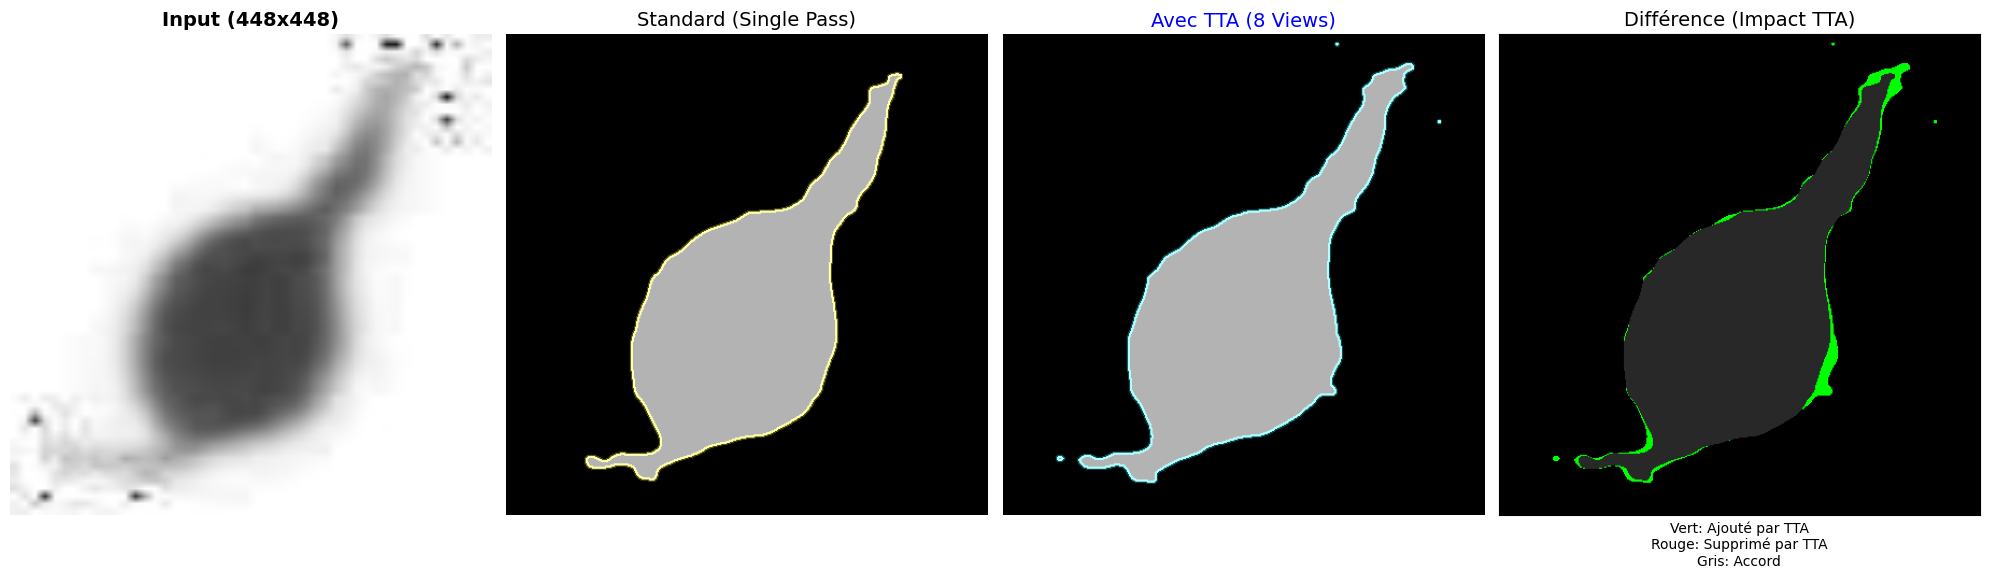

In [ ]:
# --- CELLULE 5 : COMPARATIF VISUEL (BASIC vs TTA) ---

def compare_basic_vs_tta():
    # 1. Initialisation
    # On s'assure que la config est chargée
    inferencer = PlanktonInferencerResized(config)
    
    # Récupération d'une image
    img_path, mask_path, class_name = get_random_sample(config.DATASET_ROOT)
    print(f"🔍 Analyse de : {img_path.name}")

    # 2. Préparation Image
    img_orig = cv2.imread(str(img_path))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_res = cv2.resize(img_orig, (config.IMG_SIZE, config.IMG_SIZE))

    # --- 3. INFÉRENCE STANDARD (Sans TTA) ---
    inferencer.cfg.USE_TTA = False  # On force la désactivation
    print("   👉 Exécution Inférence Standard (Single Pass)...")
    mask_basic = inferencer.predict_resized(img_res)
    
    # --- 4. INFÉRENCE TTA (Avec TTA) ---
    inferencer.cfg.USE_TTA = True   # On force l'activation
    print("   👉 Exécution Inférence TTA (8-View Ensemble)...")
    mask_tta = inferencer.predict_resized(img_res, mode="max")
    
    # --- 5. CALCUL DES DIFFÉRENCES ---
    # Où est-ce que les résultats sont différents ?
    # Diff = 1 si les masques ne sont pas d'accord, 0 sinon
    diff_map = np.logical_xor(mask_basic, mask_tta).astype(np.uint8)
    
    # Pour savoir si TTA a ajouté ou enlevé de la matière :
    # Ajouté par TTA = (TTA == 1) et (Basic == 0)
    added_by_tta = np.logical_and(mask_tta == 1, mask_basic == 0)
    # Enlevé par TTA = (TTA == 0) et (Basic == 1)
    removed_by_tta = np.logical_and(mask_tta == 0, mask_basic == 1)

    # Création image différence colorée
    # Fond noir
    diff_viz = np.zeros((config.IMG_SIZE, config.IMG_SIZE, 3), dtype=np.uint8)
    # Gris foncé pour l'accord (ce qui est commun)
    common_area = np.logical_and(mask_basic == 1, mask_tta == 1)
    diff_viz[common_area] = [40, 40, 40] 
    
    # Vert Fluo = Ce que le TTA a TROUVÉ en plus (Gain)
    diff_viz[added_by_tta] = [0, 255, 0]
    
    # Rouge = Ce que le TTA a NETTOYÉ (Suppression de bruit supposé)
    diff_viz[removed_by_tta] = [255, 0, 0]

    # --- 6. VISUALISATION ---
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    
    # A. Image Originale
    axs[0].imshow(img_res)
    axs[0].set_title(f"Input ({config.IMG_SIZE}x{config.IMG_SIZE})", fontsize=14, fontweight='bold')
    axs[0].axis("off")
    
    # B. Inférence Standard
    axs[1].imshow(mask_basic, cmap='gray')
    axs[1].set_title("Standard (Single Pass)", fontsize=14)
    axs[1].axis("off")
    # Petit contour pour aider la lecture
    contours_b, _ = cv2.findContours(mask_basic, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # On dessine sur une copie transparente pour l'affichage matplotlib
    overlay_b = np.zeros_like(img_res)
    cv2.drawContours(overlay_b, contours_b, -1, (255, 255, 0), 2)
    axs[1].imshow(overlay_b, alpha=0.3)

    # C. Inférence TTA
    axs[2].imshow(mask_tta, cmap='gray')
    axs[2].set_title("Avec TTA (8 Views)", fontsize=14, color='blue')
    axs[2].axis("off")
    contours_t, _ = cv2.findContours(mask_tta, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay_t = np.zeros_like(img_res)
    cv2.drawContours(overlay_t, contours_t, -1, (0, 255, 255), 2)
    axs[2].imshow(overlay_t, alpha=0.3)

    # D. Différence
    axs[3].imshow(diff_viz)
    axs[3].set_title("Différence (Impact TTA)", fontsize=14)
    axs[3].set_xlabel("Vert: Ajouté par TTA\nRouge: Supprimé par TTA\nGris: Accord")
    # Hack pour afficher le xlabel sans les ticks
    axs[3].set_xticks([])
    axs[3].set_yticks([])
    
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
if __name__ == "__main__":
    # Lance plusieurs fois pour tomber sur un cas intéressant
    # Le TTA change souvent les bords ou les fines antennes
    compare_basic_vs_tta()
